In [64]:
import datetime as dt
import math
import os
import sys

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns

from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential

from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor, plot_importance

In [65]:
path = 'household_power_consumption.csv'
df = pd.read_csv(path, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)
df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2220\2448216108.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(path, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


#Pre-processing

In [66]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [67]:
df = df.fillna(method='ffill')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2220\569672361.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [68]:
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [69]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [70]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute
df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2220\936537008.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime,Year,Month,Day,Hour,Minute
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,2006,12,16,17,24
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,2006,12,16,17,25
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,2006,12,16,17,26
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,2006,12,16,17,27
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,2006,12,16,17,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00,2010,11,26,20,58
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010-11-26 20:59:00,2010,11,26,20,59
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00,2010,11,26,21,0
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010-11-26 21:01:00,2010,11,26,21,1


In [71]:
def is_holiday(date):
    year = int(date.split('/')[2])
    month = int(date.split('/')[1])
    day = int(date.split('/')[0])

    if dt.datetime(year, month, day).weekday() >= 5:
        return 1.0
    else:
        return 0.0

for data in [df]:
    data['Is_holiday'] = data['Date'].apply(lambda x: is_holiday(x))
    data['Light']      = data['Time'].apply(lambda x: 1.0 if int(x[:2]) >= 6 and int(x[:2]) < 18 else 0.0)
    data['Time']       = data['Time'].apply(lambda x: (int(x[:2]) * 60.0 + int(x[3:5])) / 1440.0)

In [72]:
df.drop(['Date'], axis=1, inplace=True)
df.drop(['DateTime'], axis=1, inplace=True)


In [73]:
df = df[df['Minute'] % 10 == 0]

#Splitting Train/Test Data

In [74]:
X = df.drop('Global_active_power', axis=1)
y = df['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Time,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,Hour,Minute,Is_holiday,Light
485216,0.680556,0.000,245.47,2.8,0.0,2.0,0.0,2007,11,18,16,20,1.0,1.0
145556,0.805556,0.264,238.77,5.0,0.0,8.0,0.0,2007,3,27,19,20,0.0,0.0
305436,0.833333,0.242,235.19,3.2,0.0,0.0,0.0,2007,7,16,20,0,0.0,0.0
260806,0.840278,0.086,240.19,5.0,0.0,0.0,18.0,2007,6,15,20,10,0.0,0.0
789126,0.729167,0.130,241.87,1.2,0.0,0.0,0.0,2008,6,16,17,30,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198796,0.222222,0.104,241.60,1.6,0.0,0.0,0.0,2009,3,28,5,20,1.0,0.0
1036946,0.826389,0.000,239.98,8.8,0.0,0.0,0.0,2008,12,5,19,50,0.0,0.0
1319326,0.923611,0.068,242.39,4.2,0.0,0.0,0.0,2009,6,19,22,10,0.0,0.0
1468676,0.638889,0.208,242.59,1.4,0.0,1.0,1.0,2009,10,1,15,20,0.0,1.0


#Modeling

In [75]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_predictions = linear_reg.predict(X_test)
linear_reg_rmse = np.sqrt(mean_squared_error(y_test, linear_reg_predictions))

print(f'Mean Absolute Error (RMSE): {linear_reg_rmse}')
linear_reg_mae = mean_absolute_error(y_test, linear_reg_predictions)
print(f'Mean Absolute Error (MAE): {linear_reg_mae}')
linear_reg_mape = np.mean(np.abs((y_test - linear_reg_predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {linear_reg_mape}%')
naive_forecast = np.mean(y_train)
y_train_pred = np.full(shape=y_train.shape, fill_value=naive_forecast)
mae_naive = mean_absolute_error(y_train, y_train_pred)
linear_reg_mase = linear_reg_mae / mae_naive
print(f'Mean Absolute Scaled Error (MASE): {linear_reg_mase}')

Mean Absolute Error (RMSE): 0.039728736206110116
Mean Absolute Error (MAE): 0.02548692713375596
Mean Absolute Percentage Error (MAPE): 4.6166731728497785%
Mean Absolute Scaled Error (MASE): 0.031223324442326027


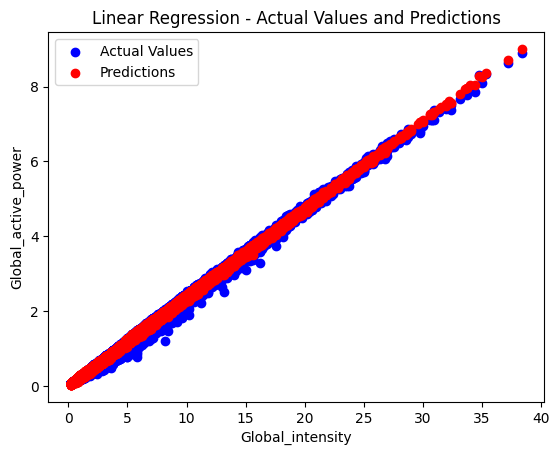

In [76]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')

plt.scatter(X_test['Global_intensity'], linear_reg_predictions, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('Linear Regression - Actual Values and Predictions')
plt.legend()
plt.show()

In [77]:
decision_tree_reg = DecisionTreeRegressor()
decision_tree_reg.fit(X_train, y_train)
decision_tree_reg_predictions = decision_tree_reg.predict(X_test)
decision_tree_reg_rmse = np.sqrt(mean_squared_error(y_test, decision_tree_reg_predictions))

print(f'Mean Absolute Error (RMSE): {decision_tree_reg_rmse}')
decision_tree_reg_mae = mean_absolute_error(y_test, decision_tree_reg_predictions)
print(f'Mean Absolute Error (MAE): {decision_tree_reg_mae}')
decision_tree_reg_mape = np.mean(np.abs((y_test - decision_tree_reg_predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {decision_tree_reg_mape}%')
naive_forecast = np.mean(y_train)
y_train_pred = np.full(shape=y_train.shape, fill_value=naive_forecast)
mae_naive = mean_absolute_error(y_train, y_train_pred)
decision_tree_reg_mase = decision_tree_reg_mae / mae_naive
print(f'Mean Absolute Scaled Error (MASE): {decision_tree_reg_mase}')

Mean Absolute Error (RMSE): 0.04400381198908414
Mean Absolute Error (MAE): 0.02199715703753677
Mean Absolute Percentage Error (MAPE): 2.9121855848551483%
Mean Absolute Scaled Error (MASE): 0.026948104311961037


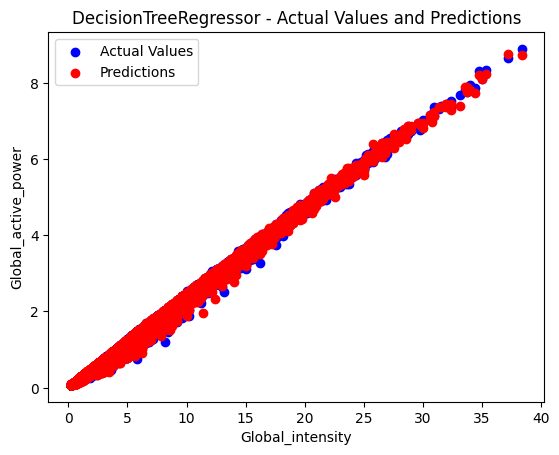

In [78]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')

plt.scatter(X_test['Global_intensity'], decision_tree_reg_predictions, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('DecisionTreeRegressor - Actual Values and Predictions')
plt.legend()
plt.show()

In [79]:
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)
random_forest_reg_predictions = random_forest_reg.predict(X_test)
random_forest_reg_rmse = np.sqrt(mean_squared_error(y_test, random_forest_reg_predictions))

print(f'Mean Absolute Error (RMSE): {random_forest_reg_rmse}')
random_forest_reg_mae = mean_absolute_error(y_test, random_forest_reg_predictions)
print(f'Mean Absolute Error (MAE): {random_forest_reg_mae}')
random_forest_reg_mape = np.mean(np.abs((y_test - random_forest_reg_predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {random_forest_reg_mape}%')
naive_forecast = np.mean(y_train)
y_train_pred = np.full(shape=y_train.shape, fill_value=naive_forecast)
mae_naive = mean_absolute_error(y_train, y_train_pred)
random_forest_reg_mase = random_forest_reg_mae / mae_naive
print(f'Mean Absolute Scaled Error (MASE): {random_forest_reg_mase}')

Mean Absolute Error (RMSE): 0.031259654561673955
Mean Absolute Error (MAE): 0.0163533291572303
Mean Absolute Percentage Error (MAPE): 2.2258693283117283%
Mean Absolute Scaled Error (MASE): 0.020034007995890748


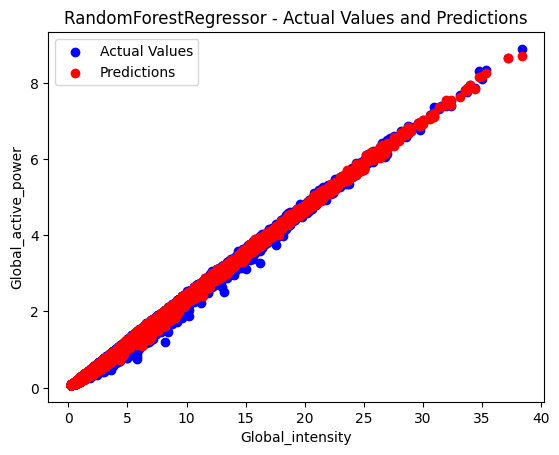

In [80]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')
plt.scatter(X_test['Global_intensity'], random_forest_reg_predictions, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('RandomForestRegressor - Actual Values and Predictions')
plt.legend()
plt.show()

In [81]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg_predictions = xgb_reg.predict(X_test)
xgb_reg_rmse = np.sqrt(mean_squared_error(y_test, xgb_reg_predictions))

print(f'Mean Absolute Error (RMSE): {xgb_reg_rmse}')
xgb_reg_mae = mean_absolute_error(y_test, xgb_reg_predictions)
print(f'Mean Absolute Error (MAE): {xgb_reg_mae}')
xgb_reg_mape = np.mean(np.abs((y_test - xgb_reg_predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {xgb_reg_mape}%')
naive_forecast = np.mean(y_train)
y_train_pred = np.full(shape=y_train.shape, fill_value=naive_forecast)
mae_naive = mean_absolute_error(y_train, y_train_pred)
xgb_reg_mase = xgb_reg_mae / mae_naive
print(f'Mean Absolute Scaled Error (MASE): {xgb_reg_mase}')

Mean Absolute Error (RMSE): 0.029107380748027985
Mean Absolute Error (MAE): 0.017328211012838355
Mean Absolute Percentage Error (MAPE): 2.8902439687090955%
Mean Absolute Scaled Error (MASE): 0.021228308599915792


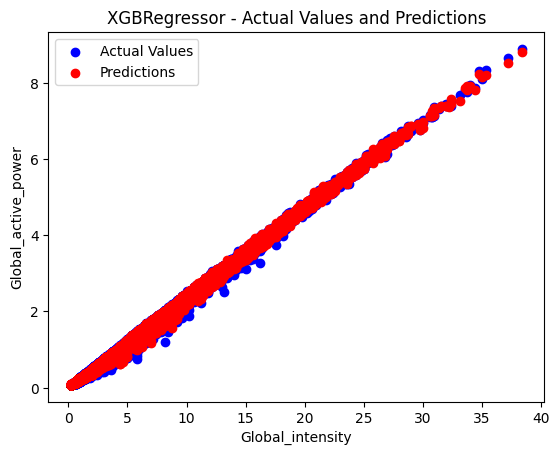

In [82]:
plt.scatter(X_test['Global_intensity'], y_test, color='blue', label='Actual Values')

plt.scatter(X_test['Global_intensity'], xgb_reg_predictions, color='red', label='Predictions')

plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.title('XGBRegressor - Actual Values and Predictions')
plt.legend()
plt.show()

In [83]:
metrics_df = pd.DataFrame({
    'Model': ['LinearRegression', 'DecisionTree', 'RandomForestRegressor', 'XGBRegressor'],
    'RMSE': [linear_reg_rmse, decision_tree_reg_rmse, random_forest_reg_rmse, xgb_reg_rmse],
    'MAE': [linear_reg_mae, decision_tree_reg_mae, random_forest_reg_mae, xgb_reg_mae],
    'MAPE': [linear_reg_mape, decision_tree_reg_mape, random_forest_reg_mape, xgb_reg_mape],
    'MASE': [linear_reg_mase, decision_tree_reg_mase, random_forest_reg_mase, xgb_reg_mase]
})

print(metrics_df)

                   Model      RMSE       MAE      MAPE      MASE
0       LinearRegression  0.039729  0.025487  4.616673  0.031223
1           DecisionTree  0.044004  0.021997  2.912186  0.026948
2  RandomForestRegressor  0.031260  0.016353  2.225869  0.020034
3           XGBRegressor  0.029107  0.017328  2.890244  0.021228


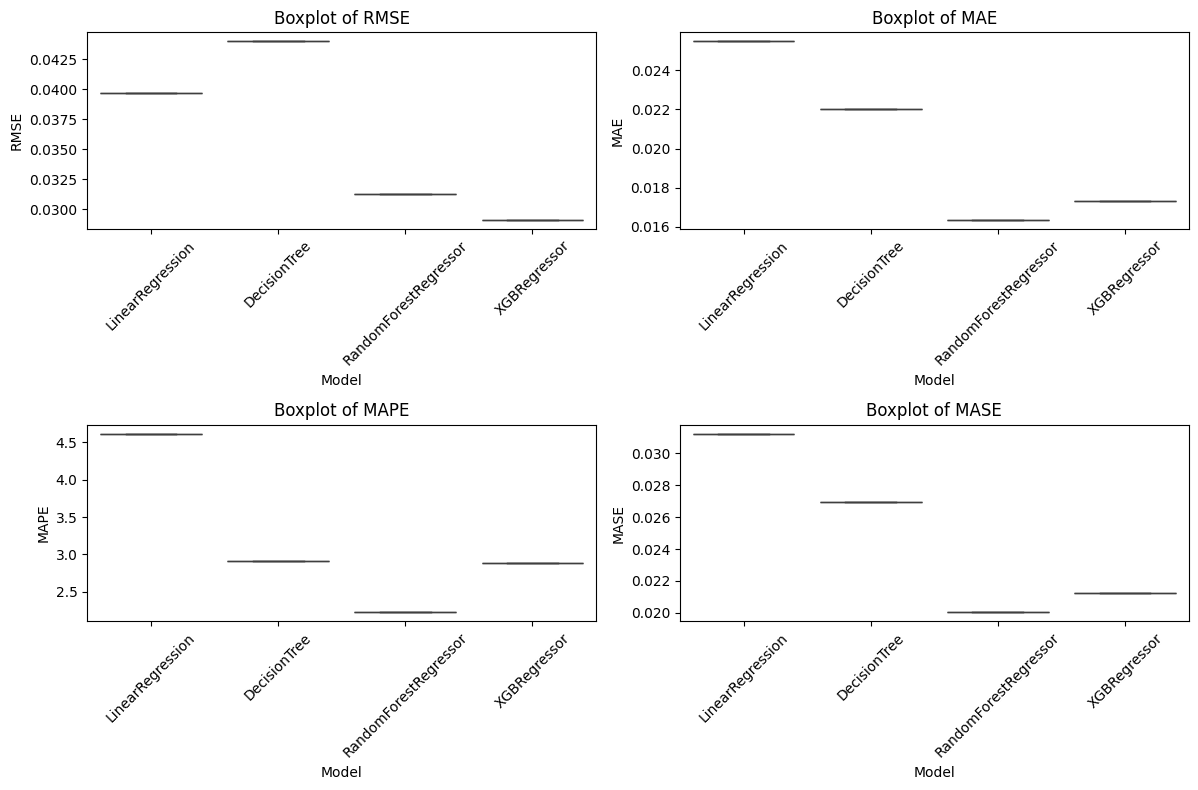

In [84]:
plt.figure(figsize=(12, 8))

for i, column in enumerate(['RMSE', 'MAE', 'MAPE', 'MASE'], start=1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Model', y=column, data=metrics_df)
    plt.title(f'Boxplot of {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [85]:
data = df.copy()
data['ds'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
data = data.rename(columns={'Global_active_power': 'y'})

In [86]:
X = df.drop('Global_active_power', axis=1)
y = df['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Time,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,Hour,Minute,Is_holiday,Light
485216,0.680556,0.000,245.47,2.8,0.0,2.0,0.0,2007,11,18,16,20,1.0,1.0
145556,0.805556,0.264,238.77,5.0,0.0,8.0,0.0,2007,3,27,19,20,0.0,0.0
305436,0.833333,0.242,235.19,3.2,0.0,0.0,0.0,2007,7,16,20,0,0.0,0.0
260806,0.840278,0.086,240.19,5.0,0.0,0.0,18.0,2007,6,15,20,10,0.0,0.0
789126,0.729167,0.130,241.87,1.2,0.0,0.0,0.0,2008,6,16,17,30,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198796,0.222222,0.104,241.60,1.6,0.0,0.0,0.0,2009,3,28,5,20,1.0,0.0
1036946,0.826389,0.000,239.98,8.8,0.0,0.0,0.0,2008,12,5,19,50,0.0,0.0
1319326,0.923611,0.068,242.39,4.2,0.0,0.0,0.0,2009,6,19,22,10,0.0,0.0
1468676,0.638889,0.208,242.59,1.4,0.0,1.0,1.0,2009,10,1,15,20,0.0,1.0


In [87]:
# Forecast random forest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = df.copy()

data['ds'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
data = data.rename(columns={'Global_active_power': 'y'})

data['dayofweek'] = data['ds'].dt.dayofweek
data['weekofyear'] = data['ds'].dt.isocalendar().week
data['quarter'] = data['ds'].dt.quarter

features = ['Global_reactive_power', 'Voltage', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
            'Year', 'Month', 'Day', 'Hour', 'Minute', 'Is_holiday',
            'Light', 'dayofweek', 'weekofyear', 'quarter']

X = data[features]
y = data['y']

train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

future_dates = pd.date_range(start=data['ds'].max() + pd.Timedelta(minutes=10), end='2024-11-26 21:00:00', freq='10T')

# Create a DataFrame for future dates
future_data = pd.DataFrame({
    'ds': future_dates,
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'Hour': future_dates.hour,
    'Minute': future_dates.minute,
    'dayofweek': future_dates.dayofweek,
    'weekofyear': future_dates.isocalendar().week,
    'quarter': future_dates.quarter,
    'Is_holiday': 0,
    'Light': 0
})

# Use previous data's median for other features
median_values = data.median()
for feature in ['Global_reactive_power', 'Voltage', 'Global_intensity',
                'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    future_data[feature] = median_values[feature]

# Predict future values
X_future = future_data[features]
future_predictions = model.predict(X_future)

# Add predictions to future_data DataFrame
future_data['y'] = future_predictions

# Output the future predictions
print(future_data[['ds', 'y']])

combined_data = pd.concat([data, future_data], ignore_index=True)

# Output the combined DataFrame
print(combined_data[['ds', 'y']])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2220\3841357520.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(start=data['ds'].max() + pd.Timedelta(minutes=10), end='2024-11-26 21:00:00', freq='10T')


                                     ds        y
2010-11-26 21:10:00 2010-11-26 21:10:00  0.61692
2010-11-26 21:20:00 2010-11-26 21:20:00  0.61758
2010-11-26 21:30:00 2010-11-26 21:30:00  0.61536
2010-11-26 21:40:00 2010-11-26 21:40:00  0.61564
2010-11-26 21:50:00 2010-11-26 21:50:00  0.61534
...                                 ...      ...
2024-11-26 20:20:00 2024-11-26 20:20:00  0.61110
2024-11-26 20:30:00 2024-11-26 20:30:00  0.60908
2024-11-26 20:40:00 2024-11-26 20:40:00  0.60870
2024-11-26 20:50:00 2024-11-26 20:50:00  0.60784
2024-11-26 21:00:00 2024-11-26 21:00:00  0.60596

[736416 rows x 2 columns]
                        ds        y
0      2006-12-16 17:30:00  3.70200
1      2006-12-16 17:40:00  3.27000
2      2006-12-16 17:50:00  3.23600
3      2006-12-16 18:00:00  2.79000
4      2006-12-16 18:10:00  3.39600
...                    ...      ...
943937 2024-11-26 20:20:00  0.61110
943938 2024-11-26 20:30:00  0.60908
943939 2024-11-26 20:40:00  0.60870
943940 2024-11-26 20:50:0

In [108]:
# Untuk Per Tahun
def predict_pertahun(tahun):
    result = combined_data[combined_data['ds'].dt.year == tahun]

    if not result.empty:
        total_yhat = result['y'].sum()
        return total_yhat
    else:
        return 'No matching year found in the predictions.'

# Untuk Per Bulan
def predict_perbulan(tahun, bulan):
    result = combined_data[(combined_data['ds'].dt.year == tahun) & (combined_data['ds'].dt.month == bulan)]

    # Sum the 'y' values for that month
    if not result.empty:
        total_yhat = result['y'].sum()
        return total_yhat
    else:
        return 'No matching year and month found in the predictions.'

# Untuk Harian
def predict_perhari(tahun, bulan, hari):
    result = combined_data[(combined_data['ds'].dt.year == tahun) &
                        (combined_data['ds'].dt.month == bulan) &
                        (combined_data['ds'].dt.day == hari)]
    # Sum the 'y' values for that day
    if not result.empty:
        total_yhat = result['y'].sum()
        return total_yhat
    else:
        return 'No matching year, month, and day found in the predictions.'

# Untuk 1 jam
def predict_perJam(tahun, bulan, hari, jam):
    # Filter the DataFrame for the specified year, month, day, and hour
    result = combined_data[(combined_data['ds'].dt.year == tahun) &
                            (combined_data['ds'].dt.month == bulan) &
                            (combined_data['ds'].dt.day == hari) &
                            (combined_data['ds'].dt.hour == jam)]

    # Sum the 'y' values for that hour
    if not result.empty:
        total_yhat = result['y'].sum()
        return total_yhat
    else:
        return 'No matching hour found in the predictions.'

# Untuk 10 menit
def predict_per10menit(tahun, bulan, hari, jam, menit):
    result = combined_data[(combined_data['ds'].dt.year == tahun) &
                            (combined_data['ds'].dt.month == bulan) &
                            (combined_data['ds'].dt.day == hari) &
                            (combined_data['ds'].dt.hour == jam) &
                            (combined_data['ds'].dt.minute // 10 == menit // 10)]

    # Sum the 'y' values for that interval
    if not result.empty:
        total_yhat = result['y'].sum()
        return total_yhat
    else:
        return 'No matching interval found in the predictions.'

In [109]:
import tkinter as tk
from tkinter import ttk

def predictElectricityinWATT():
    s = model_combo.get()
    y = year_entry.get()
    m = month_entry.get()
    d = date_entry.get()
    h = hour_entry.get()
    mi = minute_entry.get()

    print(f"Selected span: {s}")
    print(f"Year: {y}, Month: {m}, Date: {d}, Hour: {h}, Minute: {mi}")

    try:
        if s == "Yearly":
            prediction = predict_pertahun(int(y))
            if isinstance(prediction, str):
                return f"{prediction}"
            else:
                rounded_prediction = round(prediction, 4)
                return f"{rounded_prediction} watt"
        elif s == "Monthly":
            prediction = predict_perbulan(int(y), int(m))
            if isinstance(prediction, str):
                return f"{prediction}"
            else:
                rounded_prediction = round(prediction, 4)
                return f"{rounded_prediction} watt"
        elif s == "Daily":
            prediction = predict_perhari(int(y), int(m), int(d))
            if isinstance(prediction, str):
                return f"{prediction}"
            else:
                rounded_prediction = round(prediction, 4)
                return f"{rounded_prediction} watt"
        elif s == "Hourly":
            prediction = predict_perJam(int(y), int(m), int(d), int(h))
            if isinstance(prediction, str):
                return f"{prediction}"
            else:
                rounded_prediction = round(prediction, 4)
                return f"{rounded_prediction} watt"
        elif s == "Every 10 Minutes":
            prediction = predict_per10menit(int(y), int(m), int(d), int(h), int(mi))
            if isinstance(prediction, str):
                return f"{prediction}"
            else:
                rounded_prediction = round(prediction, 4)
                return f"{rounded_prediction} watt"
        else:
            return "Invalid Input!"
    except Exception as e:
        return f"Error: {str(e)}"


def update_result_label():
    result_text = predictElectricityinWATT()
    result_label.config(text=result_text)

root = tk.Tk()
root.geometry("350x400")

model_label = tk.Label(root, text="Select Prediction time-span:")
model_label.pack()

model_combo = ttk.Combobox(root, values=["Yearly", "Monthly", "Daily", "Hourly", "Every 10 Minutes"])
model_combo.pack()

year_label = tk.Label(root, text="Enter year:")
year_label.pack()

year_entry = tk.Entry(root)
year_entry.pack()

month_label = tk.Label(root, text="Enter month:")
month_label.pack()

month_entry = tk.Entry(root)
month_entry.pack()

date_label = tk.Label(root, text="Enter date:")
date_label.pack()

date_entry = tk.Entry(root)
date_entry.pack()

hour_label = tk.Label(root, text="Enter hour:")
hour_label.pack()

hour_entry = tk.Entry(root)
hour_entry.pack()

minute_label = tk.Label(root, text="Enter minute (10 minute span):")
minute_label.pack()

minute_entry = tk.Entry(root)
minute_entry.pack()

button = tk.Button(root, text="Predict", command=update_result_label)
button.pack()

result_label = tk.Label(root, text="")
result_label.pack()

# Function to update fields based on combobox selection
def update_fields(event):
    month_entry.config(state=tk.NORMAL)
    date_entry.config(state=tk.NORMAL)
    hour_entry.config(state=tk.NORMAL)
    minute_entry.config(state=tk.NORMAL)
    selection = model_combo.get()
    if selection == "Yearly":
        month_entry.config(state=tk.DISABLED)
        date_entry.config(state=tk.DISABLED)
        hour_entry.config(state=tk.DISABLED)
        minute_entry.config(state=tk.DISABLED)
    elif selection == "Monthly":
        month_entry.config(state=tk.NORMAL)
        date_entry.config(state=tk.DISABLED)
        hour_entry.config(state=tk.DISABLED)
        minute_entry.config(state=tk.DISABLED)
    elif selection == "Daily":
        month_entry.config(state=tk.NORMAL)
        date_entry.config(state=tk.NORMAL)
        hour_entry.config(state=tk.DISABLED)
        minute_entry.config(state=tk.DISABLED)
    elif selection == "Hourly":
        month_entry.config(state=tk.NORMAL)
        date_entry.config(state=tk.NORMAL)
        hour_entry.config(state=tk.NORMAL)
        minute_entry.config(state=tk.DISABLED)
    elif selection == "Every 10 Minutes":
        month_entry.config(state=tk.NORMAL)
        date_entry.config(state=tk.NORMAL)
        hour_entry.config(state=tk.NORMAL)
        minute_entry.config(state=tk.NORMAL)

# Bind combobox selection event to update_fields function
model_combo.bind("<<ComboboxSelected>>", update_fields)

root.mainloop()


Selected span: Yearly
Year: 2222, Month: , Date: , Hour: , Minute: 
Selected span: Yearly
Year: 2022, Month: , Date: , Hour: , Minute: 
Selected span: Monthly
Year: 2022, Month: 22, Date: , Hour: , Minute: 
Selected span: Monthly
Year: 2022, Month: 12, Date: , Hour: , Minute: 
Selected span: Daily
Year: 2022, Month: 12, Date: 31, Hour: , Minute: 
Selected span: Daily
Year: 2022, Month: 12, Date: 33, Hour: , Minute: 
Selected span: Daily
Year: 2022, Month: 12, Date: 31, Hour: , Minute: 
Selected span: Hourly
Year: 2022, Month: 12, Date: 31, Hour: 12, Minute: 
Selected span: Hourly
Year: 2022, Month: 12, Date: 31, Hour: 24, Minute: 
Selected span: Hourly
Year: 2022, Month: 12, Date: 31, Hour: 23, Minute: 
Selected span: Hourly
Year: 2022, Month: 12, Date: 31, Hour: 24, Minute: 
Selected span: Hourly
Year: 2022, Month: 12, Date: 31, Hour: 23, Minute: 
Selected span: Every 10 Minutes
Year: 2022, Month: 12, Date: 31, Hour: 23, Minute: 14
Selected span: Every 10 Minutes
Year: 2022, Month: 12